# Calculations of typical plasma parameters

**NOTE**:
1. All temperatures given in electron volts
2. Fully ionized gas assumed

In [1]:
import scipy.constants as cst

from IPython.display import display, HTML

from sympy import symbols, simplify, sympify
from sympy import init_printing
from sympy import Eq, S
from sympy import sqrt, ln

init_printing()

## User input

In [2]:
gas  = 'H'
NNum = 3      # Degrees of freedom
#n_e  = 3.0e19 # [m-3]
n_e  = 2.0e18 # [m-3] Lowered value to lower collisionality
T_e  = 12.0   # [eV]
T_i  = 5.00   # [eV]
BNum = 2.0e-1 # [T]
SNum = 1e24   # [1/m3 s] Particle creation rate

In [3]:
showEqs         = True
showPartialSubs = False
showValue       = True
scientific      = True

In [4]:
# Hiding coding cells
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
def eVToJ(var):
    """Converts from eV to J"""
    
    return var*cst.eV

In [6]:
T_e = eVToJ(T_e)
T_i = eVToJ(T_i)

In [7]:
def dispDict(dictionary, scientific=False):
    """
    Display the contents of a dictionary
    
    If scientific = True, the output will be printed in scientific units
    """
    
    if scientific:
        for key in dictionary:
            string = "{} = {:.3e}".format(dictionary[key].lhs, dictionary[key].rhs)
            print(string)
    else:
        for key in dictionary:
            display(dictionary[key])

In [8]:
def subsConst(dictionary, gas = 'H', additionalReplacements = None, evalf = False):
    """
    Substitutes symbols with physical constants.
    
    Input
    additionalReplacements - Dictionary of additional replacements
    evalf                  - If True, the expression is going to be numerically evaluated
    
    NOTE: Ti and Te must be given in Joules in this function 
    """
    
    implementedGases = ['H', 'D', 'T', 'He', 'Ne', 'Ar']
    if gas == 'H':
        m_i = cst.m_p
    elif gas == 'D':
        m_i = cst.m_p + cst.m_n
    elif gas == 'T':
        m_i = cst.m_p + 2*cst.m_n
    elif gas == 'He':
        # Source: http://www.ciaaw.org/atomic-weights.htm
        m_i = 4.002602*cst.atomic_mass
    elif gas == 'Ne':
        # Source: http://www.ciaaw.org/atomic-weights.htm
        m_i = 20.1797*cst.atomic_mass
    elif gas == 'Ar':
        # Source: http://www.ciaaw.org/atomic-weights.htm
        m_i = 39.948*cst.atomic_mass
    else:
        raise NotImplementedError("{} not implemented. Implemented gases are {}".format(gas, implementedGases))

    if additionalReplacements is not None:
        for addRepKey in additionalReplacements:
            for dictKey in dictionary:
                dictionary[dictKey] = dictionary[dictKey].subs(addRepKey, additionalReplacements[addRepKey])
        
    # List of replacements
    replacements = [\
                    (mi      , m_i          ),\
                    (pi      , cst.pi       ),\
                    (me      , cst.m_e      ),\
                    (epsilon0, cst.epsilon_0),\
                    (mu0     , cst.mu_0     ),\
                    (q       , cst.e        ),\
                   ]
    
    for key in dictionary:
        dictionary[key] = simplify(dictionary[key].subs(replacements))
        if evalf:
            dictionary[key] = Eq(dictionary[key].lhs, dictionary[key].rhs.evalf())
        
    return dictionary

## Symbol definition

In [9]:
ne, me, mi, Te, Ti = symbols('n_e, m_e, m_i, T_e, T_i')
lambdaD, rhoLe, rhoLi, rhoS = symbols('lambda_D, rho_Le, rho_Li, rho_S')
ompe, omce, ompi, omci = symbols('omega_pe, omega_ce, omega_pi, omega_ci')
vthe, vthi, vA, cs, N = symbols('v_the, v_thi, v_A, c_s, N')
beta, betaAlt = symbols('beta, beta_alt')
B, epsilon0, mu0, q = symbols('B, epsilon_0, mu_0, q')
Lambda, pi, mu = symbols('Lambda, pi, mu')
nuei, nuee, nuii, nuie, nuen, nuin = symbols('nu_ei, nu_ee, nu_ii, nu_ie, nu_en, nu_in')
S, nuS = symbols('S, nu_S')

# Dictionary for all formulas
eqs = {}
# Dictionary for partially subs
partSubs = {}
# Dictionary for values
vals = {}

additionalReplacements = {ne: n_e ,\
                          Te: T_e ,\
                          Ti: T_i ,\
                          B : BNum,\
                          N : NNum,\
                          S : SNum
                         }

## Thermal quantities

In [10]:
velocities = {}
# Thermal velocity: Particle has energy kbT
# https://en.wikipedia.org/wiki/Thermal_velocity
thermalEVel = Eq(vthe, sqrt(2*Te/me))
thermalIVel = Eq(vthi, sqrt(2*Ti/mi))
# Pecseli: Low frequency waves and turbulence in magnitized plasmas (draft) page 156
alfvenVel = Eq(vA, sqrt(B**2/(ne*mi*mu0)))
ionAcoustic = Eq(cs, sqrt((Te+((N+2)/N)*Ti)/mi))

velocities[thermalEVel.lhs] = thermalEVel
velocities[thermalIVel.lhs] = thermalIVel
velocities[alfvenVel.lhs]   = alfvenVel
velocities[ionAcoustic.lhs] = ionAcoustic

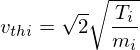

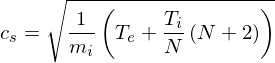

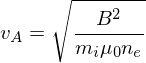

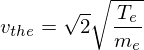

In [11]:
if showEqs:
    dispDict(velocities)
eqs.update(velocities)

In [12]:
velocities = subsConst(velocities, gas = gas)
if showPartialSubs:
    dispDict(velocities)
partSubs.update(velocities)

In [13]:
velocities = subsConst(velocities, gas = gas, additionalReplacements = additionalReplacements, evalf=True)
if showValue:
    dispDict(velocities, scientific = scientific)
vals.update(velocities)

v_thi = 3.095e+4
c_s = 4.413e+4
v_A = 3.085e+6
v_the = 2.055e+6


## Frequencies

In [14]:
frequencies = {}

plasmaFreq = Eq(ompe, sqrt(ne*q**2/(me*epsilon0)))
ionCyclotron = Eq(omci, q*B/mi)
elCyclotron = Eq(omce, q*B/me)

frequencies[plasmaFreq.lhs] = plasmaFreq
frequencies[ionCyclotron.lhs] = ionCyclotron
frequencies[elCyclotron.lhs] = elCyclotron

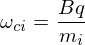

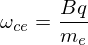

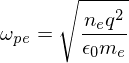

In [15]:
if showEqs:
    dispDict(frequencies)
eqs.update(frequencies)

In [16]:
frequencies = subsConst(frequencies, gas = gas)
if showPartialSubs:
    dispDict(frequencies)
partSubs.update(frequencies)

In [17]:
frequencies = subsConst(frequencies, gas = gas, additionalReplacements=additionalReplacements, evalf=True)
if showValue:
    dispDict(frequencies, scientific = scientific)
vals.update(frequencies)

omega_ci = 1.916e+7
omega_ce = 3.518e+10
omega_pe = 7.978e+10


## Sizes

In [18]:
sizes = {}

debyeLen = Eq(lambdaD, sqrt(epsilon0*Te/(ne*q**2)))
larmourERadius = Eq(rhoLe, me*vthe/(q*B))
larmourIRadius = Eq(rhoLi, mi*vthi/(q*B))
hybridRadius = Eq(rhoS, cs/omci)

sizes[debyeLen.lhs] = debyeLen
sizes[larmourERadius.lhs] = larmourERadius
sizes[larmourIRadius.lhs] = larmourIRadius
sizes[hybridRadius.lhs] = hybridRadius

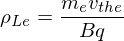

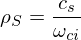

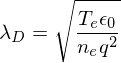

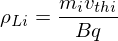

In [19]:
if showEqs:
    dispDict(sizes)
eqs.update(sizes)

In [20]:
sizes = subsConst(sizes, gas = gas)
if showPartialSubs:
    dispDict(sizes)
partSubs.update(sizes)

In [21]:
sizes = subsConst(sizes, gas = gas, additionalReplacements={**additionalReplacements,\
                                                            omci:vals[omci].rhs     ,\
                                                            vthe:vals[vthe].rhs     ,\
                                                            vthi:vals[vthi].rhs     ,\
                                                            cs  :vals[cs].rhs       ,\
                                                           }, evalf=True)
if showValue:
    dispDict(sizes, scientific = scientific)
vals.update(sizes)

rho_Le = 5.841e-5
rho_S = 2.304e-3
lambda_D = 1.821e-5
rho_Li = 1.616e-3


## Collisions

**NOTE**: No easy functional expression for neutral collisions other than the ones with the rate coefficients

### Coulomb logarithm

In [22]:
coulLog = {}

# Friedberg: Plasma Physics and Fusion Energy - equation (9.35)
coulombLog = Eq(ln(Lambda), ln(12*pi*(epsilon0*Te)**(3/2)/(sqrt(ne)*q**3)))
                
coulLog[coulombLog.lhs] = coulombLog

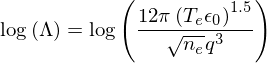

In [23]:
if showEqs:
    dispDict(coulLog)            
eqs.update(coulLog)

In [24]:
coulLog = subsConst(coulLog, gas = gas)
if showPartialSubs:
    dispDict(coulLog)
partSubs.update(coulLog)

In [25]:
coulLog = subsConst(coulLog, gas = gas, additionalReplacements={**additionalReplacements}, evalf=True)
if showValue:
    dispDict(coulLog, scientific = scientific)
vals.update(coulLog)

log(Lambda) = 1.303e+1


### Collision frequencies

In [26]:
# TODO: Add neutral plot
collisions = {}

# Friedberg: Plasma Physics and Fusion Energy - equation (9.49) [Agrees with Bellan page 489]
eiCollision = Eq(nuei, 1/(4*pi)*(q**4*ne/(epsilon0**2*me**2))*ln(Lambda)*(1/vthe**3))
# Friedberg: Plasma Physics and Fusion Energy - equation (9.52)                
eeCollision = Eq(nuee, 1/(2*pi)*(q**4*ne/(epsilon0**2*me**2))*ln(Lambda)*(1/vthe**3))
iiCollision = Eq(nuii, 1/(2*pi)*(q**4*ne/(epsilon0**2*mi**2))*ln(Lambda)*(1/vthi**3))
ieCollision = Eq(nuie, 1/(4*pi)*(q**4*ne/(epsilon0**2*me*mi))*ln(Lambda)*(1/vthe**3))
                
collisions[eiCollision.lhs] = eiCollision
collisions[eeCollision.lhs] = eeCollision
collisions[iiCollision.lhs] = iiCollision
collisions[ieCollision.lhs] = ieCollision

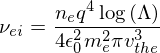

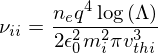

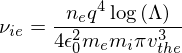

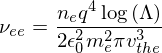

In [27]:
if showEqs:
    dispDict(collisions)            
eqs.update(collisions)

In [28]:
collisions = subsConst(collisions, gas = gas)
if showPartialSubs:
    dispDict(collisions)
partSubs.update(collisions)

In [29]:
collisions = subsConst(collisions, gas = gas, additionalReplacements={**additionalReplacements               ,\
                                                                      vthe:vals[vthe].rhs                    ,\
                                                                      vthi:vals[vthi].rhs                    ,\
                                                                      coulombLog.lhs:vals[coulombLog.lhs].rhs,\
                                                                     }, evalf=True)
if showValue:
    dispDict(collisions, scientific = scientific)
vals.update(collisions)

nu_ei = 2.422e+6
nu_ii = 4.203e+5
nu_ie = 1.319e+3
nu_ee = 4.844e+6


## Additional parameters

In [30]:
additionals = {}

# Pecseli: Low frequency waves and turbulence in magnitized plasmas (draft) page 40
plasmaBeta = Eq(beta, ne*(Te+((N+2)/N)*Ti)/(B**2/(2*mu0)))
plasmaBetaAlt = Eq(betaAlt, 2*cs**2/vA**2)
massRatio = Eq(mu, mi/me)
creationRate = Eq(nuS, S/ne)

additionals[plasmaBeta.lhs] = plasmaBeta
additionals[plasmaBetaAlt.lhs] = plasmaBetaAlt
additionals[massRatio.lhs] = massRatio        
additionals[creationRate.lhs] = creationRate

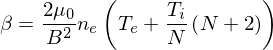

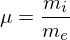

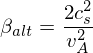

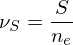

In [31]:
if showEqs:
    dispDict(additionals)
eqs.update(additionals)

In [32]:
additionals = subsConst(additionals, gas = gas)
if showPartialSubs:
    dispDict(additionals)
partSubs.update(additionals)

In [33]:
additionals = subsConst(additionals, gas = gas, additionalReplacements = {**additionalReplacements,\
                                                                          cs:vals[cs].rhs         ,\
                                                                          vA:vals[vA].rhs         ,\
                                                                         },evalf=True)
if showValue:
    dispDict(additionals, scientific = scientific)
vals.update(additionals)

beta = 4.094e-4
mu = 1.836e+3
beta_alt = 4.094e-4
nu_S = 5.000e+5


## Normalized parameters

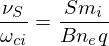

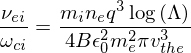

In [34]:
normEq = {}

normNuEiEq = Eq(eqs[nuei].lhs/eqs[omci].lhs, eqs[nuei].rhs/eqs[omci].rhs)
normNuSEq = Eq(eqs[nuS].lhs/eqs[omci].lhs, eqs[nuS].rhs/eqs[omci].rhs)

normEq[normNuEiEq.rhs] = normNuEiEq
normEq[normNuSEq.rhs] = normNuSEq

eqs.update(normEq)
if showEqs:
    dispDict(normEq)

In [35]:
normPartSubs = {}
normNuEiPartial = Eq(partSubs[nuei].lhs/partSubs[omci].lhs, partSubs[nuei].rhs/partSubs[omci].rhs)
normNuSPartial = Eq(partSubs[nuS].lhs/partSubs[omci].lhs, partSubs[nuS].rhs/partSubs[omci].rhs)

normPartSubs[normNuEiPartial.rhs] = normNuEiPartial
normPartSubs[normNuSPartial.rhs] = normNuSPartial

partSubs.update(normPartSubs)
if showPartialSubs:
    dispDict(normPartSubs)

In [36]:
normVals = {}
normNuEiVals = Eq(vals[nuei].lhs/vals[omci].lhs, vals[nuei].rhs/vals[omci].rhs)
normNuSVals = Eq(vals[nuS].lhs/vals[omci].lhs, vals[nuS].rhs/vals[omci].rhs)

normVals[normNuEiVals.rhs] = normNuEiVals
normVals[normNuSVals.rhs] = normNuSVals

vals.update(normVals)
if showValue:
    dispDict(normVals, scientific = scientific)

nu_S/omega_ci = 2.610e-2
nu_ei/omega_ci = 1.264e-1
